# Importing the required libraries

In [1]:
import torch
import pandas as pd
import numpy as np
import os
import warnings
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForSequenceClassification, DistilBertForSequenceClassification, AutoModelForSeq2SeqLM
from tqdm import tqdm
from torchvision import models
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader
from keras.preprocessing import image
from torchmetrics.classification import MultilabelF1Score
from sklearn.metrics import average_precision_score, ndcg_score

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

### Setting up the environment
***

In [2]:
warnings.filterwarnings("ignore")

***

# Data Preprocessing

In [3]:
genres = ["Crime", "Thriller", "Fantasy", "Horror", "Sci-Fi", "Comedy", "Documentary", "Adventure", "Film-Noir", "Animation", "Romance", "Drama", "Western", "Musical", "Action", "Mystery", "War", "Children\'s"]
mapping = {}
for i in range(len(genres)):
    mapping[i] = genres[i]
mapping

{0: 'Crime',
 1: 'Thriller',
 2: 'Fantasy',
 3: 'Horror',
 4: 'Sci-Fi',
 5: 'Comedy',
 6: 'Documentary',
 7: 'Adventure',
 8: 'Film-Noir',
 9: 'Animation',
 10: 'Romance',
 11: 'Drama',
 12: 'Western',
 13: 'Musical',
 14: 'Action',
 15: 'Mystery',
 16: 'War',
 17: "Children's"}

***

In [4]:
trainset = pd.read_csv('/kaggle/input/ml-dataset-2023s1/trainset.csv')
testset = pd.read_csv('/kaggle/input/ml-dataset-2023s1/testset.csv')
trainset.label = trainset.label.apply(lambda x: eval(x))
testset.label = testset.label.apply(lambda x: eval(x))
trainset.img_path = trainset.img_path.apply(lambda x: x.replace('\\', '/'))
testset.img_path = testset.img_path.apply(lambda x: x.replace('\\', '/'))

In [5]:
print(len(trainset), len(testset))

3106 777


In [6]:
tokenizer_gen = AutoTokenizer.from_pretrained("MBZUAI/LaMini-Flan-T5-248M")
model_gen = AutoModelForSeq2SeqLM.from_pretrained("MBZUAI/LaMini-Flan-T5-248M")

tokenizer_config.json:   0%|          | 0.00/2.50k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

In [7]:
def generate_plot(df: pd.DataFrame, model: AutoModelForSeq2SeqLM, tokenizer: AutoTokenizer, device) -> pd.DataFrame:
    quote = 'What is the story of the movie {}?'
    model_gen.to(device)
    model_gen.eval()

    for i in tqdm(range(len(df))):
        with torch.no_grad():
            input_ids = tokenizer(quote.format(df.title[i]), return_tensors='pt').input_ids.to(device)
            output = model.generate(input_ids, max_length=256, do_sample=True, temperature=0.09)
            df.loc[i, 'plot'] = tokenizer.decode(output[0], skip_special_tokens=True)
    return df

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
# trainset = generate_plot(trainset, model_gen, tokenizer_gen, device)
# testset = generate_plot(testset, model_gen, tokenizer_gen, device)

# Model Implementation

### Sub-models
***

In [10]:
tokenizer1 = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model1 = DistilBertForSequenceClassification .from_pretrained("distilbert-base-uncased", problem_type="multi_label_classification", num_labels=18)
model1.config.id2label = mapping

tokenizer2 = AutoTokenizer.from_pretrained("dduy193/plot-classification")
model2 = AutoModelForSequenceClassification.from_pretrained("dduy193/plot-classification")
model2.config.id2label = mapping

model3 = models.resnet101(pretrained=False)
model3.fc = torch.nn.Linear(2048, len(genres))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model1.to(device)
model2.to(device)
model3.to(device)
device

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

device(type='cuda')

### Deep Fusion Multimodal Model
***

In [11]:
class Multimodal(torch.nn.Module):
    def __init__(self, model1, model2, model3):
        super().__init__()
        self.model1 = model1
        self.model2 = model2
        self.model3 = model3
        self.fc1 = torch.nn.Linear(18, 18)
        self.fc2 = torch.nn.Linear(18, 18)
        self.fc3 = torch.nn.Linear(18, 18)

    def forward(self, 
                title_input_ids, title_attention_mask,
                plot_input_ids, plot_attention_mask,
                image_input):
        title_output = self.model1(title_input_ids, title_attention_mask)
        plot_output = self.model2(plot_input_ids, plot_attention_mask)
        image_output = self.model3(image_input)

        title_output = self.fc1(title_output.logits)
        plot_output = self.fc2(plot_output.logits)
        image_output = self.fc3(image_output)
        
        output = torch.add(title_output, plot_output)
        output = torch.add(output, image_output)
        return output

# Custom Datasets & Data Loaders

***
### Custom Dataset
***

In [12]:
class Poroset(torch.utils.data.Dataset):
    def __init__(self, df, 
                 tokenizer1, tokenizer2, 
                 max_len1=64, max_len2=256,
                 device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
        self.df = df
        self.tokenizer1 = tokenizer1
        self.tokenizer2 = tokenizer2
        self.max_len1 = max_len1
        self.max_len2 = max_len2
        self.device = device
        self.transform = v2.Compose([
            v2.Resize((224, 224)),
            v2.ToTensor(),
            v2.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        title = row['title']
        # Truncate title if it is too long
        if len(title) > self.max_len1:
            title = title[:self.max_len1]

        plot = row['plot']
        # Truncate plot if it is too long
        if len(plot) > self.max_len2:
            plot = plot[:self.max_len2]

        label = row['label']
        title_encoding = self.tokenizer1(title, truncation=True, padding='max_length', max_length=self.max_len1, return_tensors='pt')
        plot_encoding = self.tokenizer2(plot, truncation=True, padding='max_length', max_length=self.max_len2, return_tensors='pt')
        
        image_path = '/kaggle/input/ml-dataset-2023s1/ml1m/' + row['img_path']
        if os.path.exists(image_path):
            image_input = image.load_img(image_path)
            image_input = self.transform(image_input)
        else:
            image_input = torch.zeros((3, 224, 224))
        
        return {
            'title': title,
            'plot': plot,
            'title_input_ids': title_encoding['input_ids'].squeeze(),
            'title_attention_mask': title_encoding['attention_mask'].squeeze(),
            'plot_input_ids': plot_encoding['input_ids'].squeeze(),
            'plot_attention_mask': plot_encoding['attention_mask'].squeeze(),
            'image_input': image_input,
            'label': torch.FloatTensor(label)
        }

In [13]:
trainset.head()

,title,img_path,label,plot
0,Washington Square (1997),ml1m/content/dataset/ml1m-images/1650.jpg,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",Washington Square is a 1997 American film abou...
1,"Net, The (1995)",ml1m/content/dataset/ml1m-images/185.jpg,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Net is a 1995 American film directed by James ...
2,Batman Returns (1992),ml1m/content/dataset/ml1m-images/1377.jpg,"[1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, ...",Batman returns to the Batman universe after a ...
3,"Boys from Brazil, The (1978)",ml1m/content/dataset/ml1m-images/3204.jpg,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","The movie Boys from Brazil, The (1978) is a ro..."
4,Dear Jesse (1997),ml1m/content/dataset/ml1m-images/1901.jpg,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",Dear Jesse is a 1997 American drama film about...


In [14]:
trainset = Poroset(df=trainset, tokenizer1=tokenizer1, tokenizer2=tokenizer2,
                   max_len1=64, max_len2=256,
                   device=device)
testset = Poroset(df=testset, tokenizer1=tokenizer1, tokenizer2=tokenizer2,
                  max_len1=64, max_len2=256,
                  device=device)


***
### Custom Data Loader
***

In [15]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True)

Check if the data loader is working properly

Title:  Sunshine (1999)
Plot:  Sunshine (1999) is a romantic comedy film about a young woman named Lily who falls in love with a man named Jack. They fall in love and fall in love, but their relationship is complicated by Jack's past and his past. The movie explores themes of love, loss
Label:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])


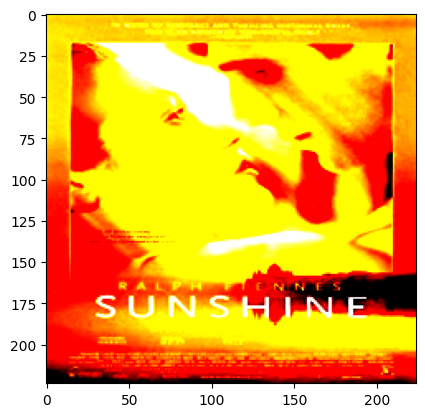

In [16]:
sample = next(iter(testloader))

# First sample of the batch
print('Title: ', sample['title'][3])
print('Plot: ', sample['plot'][3])
print('Label: ', sample['label'][3])
plt.imshow(sample['image_input'][3].permute(1, 2, 0))

# Setting up the Trainer

***
### GPU & Model Configuration
***

In [17]:
model = Multimodal(model1, model2, model3)
model.to(device)
device

# Freeze layers
for param in model.model2.parameters():
    param.requires_grad = False

***
### Setting up loss function & optimizer
***

In [18]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

optimizer = torch.optim.Adam(params=model.parameters(), lr=2e-5)

***
### Trainer & Validation
***

In [19]:
history_loss = []
history_f1 = []
history_mapk = []
history_ndcg = []
def train(epoch):
    model.train()
    f1 = MultilabelF1Score(num_labels=18, threshold=0.5, average='macro')
    f1.to(device)

    actual = []
    predicted = []
    for _, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
        title_input_ids = data['title_input_ids'].to(device)
        title_attention_mask = data['title_attention_mask'].to(device)
        plot_input_ids = data['plot_input_ids'].to(device)
        plot_attention_mask = data['plot_attention_mask'].to(device)
        image_input = data['image_input'].to(device)
        label = data['label'].to(device)

        optimizer.zero_grad()
        outputs = model(
            title_input_ids, title_attention_mask,
            plot_input_ids, plot_attention_mask,
            image_input
        )
        
        loss = loss_fn(outputs, label)
        loss.backward()
        optimizer.step()

        f1.update(outputs.sigmoid(), label)
        
        probabilities = outputs.sigmoid().cpu().detach().numpy()

        actual.append(label.cpu().detach().numpy())
        predicted.append(probabilities)
    actual_flat = np.vstack(actual)
    predicted_flat = np.vstack(predicted)
    maps = average_precision_score(actual_flat, predicted_flat, average="samples")
    
    ndcg = ndcg_score(actual_flat, predicted_flat)
    
    print(f'Epoch: {epoch}, Train Loss: {loss.item()}, Train F1: {f1.compute().item()}, Train MAP: {maps}, Train NDCG: {ndcg}')
    history_loss.append(loss.item())
    history_f1.append(f1.compute().item())
    history_mapk.append(maps)
    history_ndcg.append(ndcg)

# Training Loop

In [20]:
for epoch in range(32):
    train(epoch)

100%|██████████| 98/98 [01:18<00:00,  1.24it/s]


Epoch: 0, Train Loss: 0.6380023956298828, Train F1: 0.1615493893623352, Train MAP: 0.2868538138656695, Train NDCG: 0.4733425494117361


100%|██████████| 98/98 [01:02<00:00,  1.56it/s]


Epoch: 1, Train Loss: 0.20452113449573517, Train F1: 0.15911796689033508, Train MAP: 0.36970567560642276, Train NDCG: 0.5412537637140072


100%|██████████| 98/98 [01:02<00:00,  1.56it/s]


Epoch: 2, Train Loss: 1.219512939453125, Train F1: 0.14611569046974182, Train MAP: 0.43003280816429457, Train NDCG: 0.5899738681466264


100%|██████████| 98/98 [01:03<00:00,  1.55it/s]


Epoch: 3, Train Loss: 0.49733319878578186, Train F1: 0.15879061818122864, Train MAP: 0.4537453964145543, Train NDCG: 0.6086232671325396


100%|██████████| 98/98 [01:03<00:00,  1.55it/s]


Epoch: 4, Train Loss: 0.19800424575805664, Train F1: 0.17705440521240234, Train MAP: 0.49058972804015605, Train NDCG: 0.6372679951339031


100%|██████████| 98/98 [01:02<00:00,  1.56it/s]


Epoch: 5, Train Loss: 0.3164418637752533, Train F1: 0.20260636508464813, Train MAP: 0.5290702834175857, Train NDCG: 0.6674661722072143


100%|██████████| 98/98 [01:02<00:00,  1.56it/s]


Epoch: 6, Train Loss: 0.39157184958457947, Train F1: 0.238995760679245, Train MAP: 0.5748992597827514, Train NDCG: 0.7030228074493886


100%|██████████| 98/98 [01:02<00:00,  1.56it/s]


Epoch: 7, Train Loss: 0.2953750789165497, Train F1: 0.26984903216362, Train MAP: 0.6273160231636236, Train NDCG: 0.7428451603366092


100%|██████████| 98/98 [01:02<00:00,  1.56it/s]


Epoch: 8, Train Loss: 0.2243884652853012, Train F1: 0.3123369812965393, Train MAP: 0.6789898592391395, Train NDCG: 0.7818296582118703


100%|██████████| 98/98 [01:02<00:00,  1.56it/s]


Epoch: 9, Train Loss: 0.32021474838256836, Train F1: 0.34886544942855835, Train MAP: 0.7322112659986463, Train NDCG: 0.8211641006008771


100%|██████████| 98/98 [01:02<00:00,  1.56it/s]


Epoch: 10, Train Loss: 0.3273795545101166, Train F1: 0.3910631537437439, Train MAP: 0.7698327318140015, Train NDCG: 0.8487160315573549


100%|██████████| 98/98 [01:02<00:00,  1.57it/s]


Epoch: 11, Train Loss: 0.12368684262037277, Train F1: 0.4239617884159088, Train MAP: 0.7958919490435816, Train NDCG: 0.8674028678139855


100%|██████████| 98/98 [01:02<00:00,  1.57it/s]


Epoch: 12, Train Loss: 0.11783574521541595, Train F1: 0.45414406061172485, Train MAP: 0.8281815465545486, Train NDCG: 0.8895786835700069


100%|██████████| 98/98 [01:02<00:00,  1.56it/s]


Epoch: 13, Train Loss: 0.018345143646001816, Train F1: 0.47877901792526245, Train MAP: 0.8442021542670666, Train NDCG: 0.8999711572264576


100%|██████████| 98/98 [01:02<00:00,  1.56it/s]


Epoch: 14, Train Loss: 0.2691822052001953, Train F1: 0.5042015314102173, Train MAP: 0.8619598414975721, Train NDCG: 0.9118576297210965


100%|██████████| 98/98 [01:03<00:00,  1.54it/s]


Epoch: 15, Train Loss: 0.077192023396492, Train F1: 0.5223862528800964, Train MAP: 0.8766882777098299, Train NDCG: 0.9220998452894026


100%|██████████| 98/98 [01:02<00:00,  1.56it/s]


Epoch: 16, Train Loss: 0.17467060685157776, Train F1: 0.5472869873046875, Train MAP: 0.8856665151265972, Train NDCG: 0.927612956990511


100%|██████████| 98/98 [01:02<00:00,  1.56it/s]


Epoch: 17, Train Loss: 0.018982166424393654, Train F1: 0.5827990770339966, Train MAP: 0.9010396060844197, Train NDCG: 0.9374411336603918


100%|██████████| 98/98 [01:02<00:00,  1.57it/s]


Epoch: 18, Train Loss: 0.011844775639474392, Train F1: 0.5997107625007629, Train MAP: 0.9068465227221998, Train NDCG: 0.9412081686248377


100%|██████████| 98/98 [01:02<00:00,  1.57it/s]


Epoch: 19, Train Loss: 0.24724435806274414, Train F1: 0.624536395072937, Train MAP: 0.917960087971901, Train NDCG: 0.9483359033618628


100%|██████████| 98/98 [01:02<00:00,  1.57it/s]


Epoch: 20, Train Loss: 0.01606348715722561, Train F1: 0.627023458480835, Train MAP: 0.9198990444325612, Train NDCG: 0.9498596343964368


100%|██████████| 98/98 [01:02<00:00,  1.56it/s]


Epoch: 21, Train Loss: 0.12419483810663223, Train F1: 0.6510038375854492, Train MAP: 0.9280116949580938, Train NDCG: 0.954751975930422


100%|██████████| 98/98 [01:02<00:00,  1.56it/s]


Epoch: 22, Train Loss: 0.051102686673402786, Train F1: 0.661782443523407, Train MAP: 0.9308463532346387, Train NDCG: 0.9565931105894429


100%|██████████| 98/98 [01:02<00:00,  1.56it/s]


Epoch: 23, Train Loss: 0.018615007400512695, Train F1: 0.6879494786262512, Train MAP: 0.9415343017119702, Train NDCG: 0.9636913810200178


100%|██████████| 98/98 [01:02<00:00,  1.57it/s]


Epoch: 24, Train Loss: 0.12504427134990692, Train F1: 0.7012491226196289, Train MAP: 0.9438102784923456, Train NDCG: 0.964992289689749


100%|██████████| 98/98 [01:02<00:00,  1.56it/s]


Epoch: 25, Train Loss: 0.023185165598988533, Train F1: 0.729793906211853, Train MAP: 0.95247773323573, Train NDCG: 0.970489132830624


100%|██████████| 98/98 [01:02<00:00,  1.57it/s]


Epoch: 26, Train Loss: 0.015627283602952957, Train F1: 0.7474939227104187, Train MAP: 0.954580217977272, Train NDCG: 0.9719341255003784


100%|██████████| 98/98 [01:02<00:00,  1.56it/s]


Epoch: 27, Train Loss: 0.0014103105058893561, Train F1: 0.7486421465873718, Train MAP: 0.9586121382016425, Train NDCG: 0.9743495262728257


100%|██████████| 98/98 [01:02<00:00,  1.56it/s]


Epoch: 28, Train Loss: 0.29243651032447815, Train F1: 0.7783758640289307, Train MAP: 0.9637231583702125, Train NDCG: 0.9776394597921105


100%|██████████| 98/98 [01:02<00:00,  1.57it/s]


Epoch: 29, Train Loss: 0.0036198075395077467, Train F1: 0.7662091255187988, Train MAP: 0.9661608561628684, Train NDCG: 0.9793606050835744


100%|██████████| 98/98 [01:02<00:00,  1.57it/s]


Epoch: 30, Train Loss: 0.039602745324373245, Train F1: 0.8106442093849182, Train MAP: 0.9716163712155341, Train NDCG: 0.9828310330609948


100%|██████████| 98/98 [01:02<00:00,  1.57it/s]


Epoch: 31, Train Loss: 0.11838477104902267, Train F1: 0.8107895255088806, Train MAP: 0.9711294013366614, Train NDCG: 0.9822425226720071


In [21]:
# Save model
torch.save(model.state_dict(), 'partially_frozen_multimodel.pt')

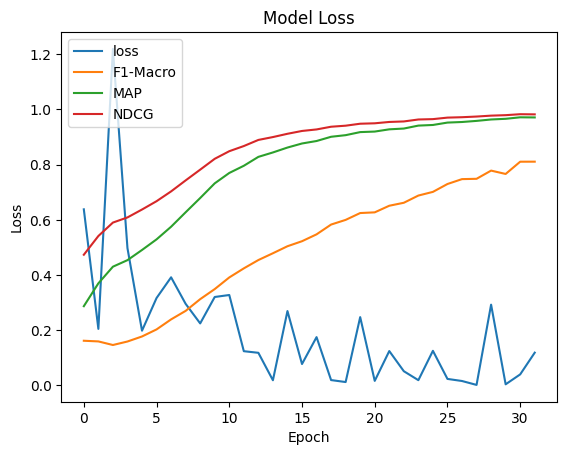

In [22]:
# Visualize
plt.plot(history_loss)
plt.plot(history_f1)
plt.plot(history_mapk)
plt.plot(history_ndcg)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'F1-Macro', 'MAP', 'NDCG'], loc='upper left')
plt.show()

# Testing the model

In [23]:
# Validation
def test(testing_loader):
    model.eval()
    f1 = MultilabelF1Score(num_labels=18, threshold=0.5, average='macro')
    f1.to(device)

    actual = []
    predicted = []

    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0), total=len(testing_loader)):
            title_input_ids = data['title_input_ids'].to(device)
            title_attention_mask = data['title_attention_mask'].to(device)
            plot_input_ids = data['plot_input_ids'].to(device)
            plot_attention_mask = data['plot_attention_mask'].to(device)
            image_input = data['image_input'].to(device)
            label = data['label'].to(device)

            outputs = model(
                title_input_ids, title_attention_mask,
                plot_input_ids, plot_attention_mask,
                image_input
            )
            f1.update(outputs.sigmoid(), label)
        
        probabilities = outputs.sigmoid().cpu().detach().numpy()

        actual.append(label.cpu().detach().numpy())
        predicted.append(probabilities)
    actual_flat = np.vstack(actual)
    predicted_flat = np.vstack(predicted)
    mapp = average_precision_score(actual_flat, predicted_flat, average="samples")
    
    ndcg = ndcg_score(actual_flat, predicted_flat)
    
    print(f'Test F1: {f1.compute().item()}, Test MAP: {mapp}, Test NDCG: {ndcg}')

In [24]:
test(testloader)

100%|██████████| 25/25 [00:12<00:00,  1.93it/s]

Test F1: 0.27938681840896606, Test MAP: 0.5135465297230003, Test NDCG: 0.6681248928775978


In [25]:
def inference(title, plot, image_input, tokenizer1=tokenizer1, tokenizer2=tokenizer2, model=model, genres=genres, device=device):
    title_input = tokenizer1(title, return_tensors='pt', padding=True, truncation=True)
    title_input_ids = title_input['input_ids'].to(device)
    title_attention_mask = title_input['attention_mask'].to(device)

    plot_input = tokenizer2(plot, return_tensors='pt', padding=True, truncation=True)
    plot_input_ids = plot_input['input_ids'].to(device)
    plot_attention_mask = plot_input['attention_mask'].to(device)

    image_input = image_input.to(device)
    print(title)
    print(plot)
    plt.imshow(image_input.permute(1, 2, 0).cpu().detach().numpy())

    output = model(title_input_ids, title_attention_mask, plot_input_ids, plot_attention_mask, image_input.unsqueeze(0))
    output = torch.sigmoid(output)
    output = output.cpu().detach().numpy()
    output = np.where(output > 0.5, 1, 0)
    output = output.squeeze()
    output = np.where(output == 1)[0]
    output = [genres[i] for i in output]
    return output

Exorcist III, The (1990)
Exorcist III is a movie about a group of rebels who rebel against the oppressive government of the Soviet Union. They are forced to flee their homes and seek refuge in a remote island in the Pacific Ocean. Along the way, they encounter various obstacles an


['Horror']

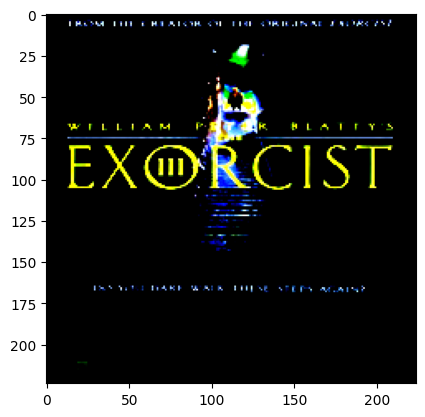

In [26]:
inference(sample['title'][1], sample['plot'][1], sample['image_input'][1])